In [1]:
import os,sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
from torchvision import datasets, transforms
from core.data import DataGenerator,DatasetsDG
from core.models import SimpleNN,EnsembleModel, SimpleCNN
from core.cf_problem import make_cf_problem

from core.optimization import run_nsga, NSGAConfig
from torch.utils.data import DataLoader, Dataset, TensorDataset
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
from torch import nn

100%|██████████| 9.91M/9.91M [00:29<00:00, 334kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 263kB/s]
100%|██████████| 1.65M/1.65M [00:05<00:00, 314kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.73MB/s]


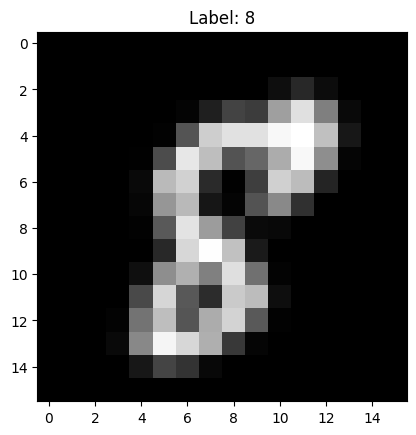

In [2]:
# load dataset and model
# Image size configuration - using 16x16 to reduce search space (256 vs 784 dimensions)
IMG_SIZE = 16

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize from 28x28 to 16x16
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root=os.path.join(root_dir, 'data'), train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=os.path.join(root_dir, 'data'), train=False, download=True, transform=transform)

DG=DatasetsDG(train_dataset, num_classes=10)
models = [SimpleCNN(16,16,input_channels=1, num_classes=10) for _ in range(10)]


# show the first image in the training dataset
image, label = DG.sample(1, seed=44)
plt.imshow(image[0].squeeze(), cmap='gray')
plt.title(f'Label: {label.argmax().item()}')
plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model in models:
    model.to(device)

criterion = nn.CrossEntropyLoss()

epochs = 100
for model in models:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Create optimizer for each model
    seed = 42 + hash(model) % 1000  # Simple way to get different seeds
    samples = DG.sample(5000, seed=seed)
    model_train_dataset = TensorDataset(samples[0].to(device), samples[1].to(device))
    train_loader = DataLoader(model_train_dataset, batch_size=512, shuffle=True)  # Create loader inside loop
    model.train()
    bar = tqdm(range(epochs), desc="Training Model", colour="blue", unit="epoch")
    running_loss = 0.0
    for epoch in bar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.argmax(dim=1))  # labels are one-hot from DG.sample()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        bar.set_postfix(loss=running_loss/(epoch+1))

Training Model: 100%|██████████| 100/100 [00:04<00:00, 20.79epoch/s, loss=3.44]


(9, tensor([8], device='cuda:0'))

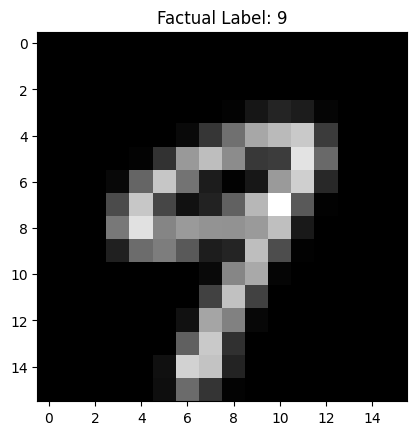

In [4]:
x_factual, y_factual = DG.sample(1, seed=1234)
plt.imshow(x_factual[0].squeeze(), cmap='gray')
plt.title(f'Factual Label: {y_factual.argmax().item()}')
target_class = 8  # Target class different from factual
target_class_tensor = torch.tensor([target_class], device=device)

problem = make_cf_problem(models[0], x_factual, target_class_tensor, DG.sample(5000, seed=5678)[0],device=device)
y_factual.argmax().item(),target_class_tensor

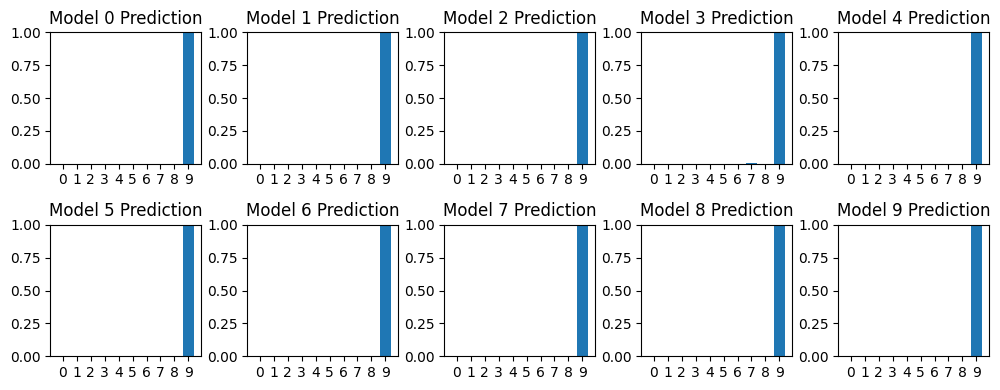

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [5]:
# visualize the each model's prediction on the factual instance using plt
plt.figure(figsize=(10, 4))
for i, model in enumerate(models):
    model.eval()
    probs=torch.zeros(10, device=device)
    with torch.no_grad():
        output = model(x_factual.to(device))
        probs += nn.functional.softmax(output, dim=1).squeeze()
    plt.subplot(2, 5, i+1)
    plt.bar(range(10), probs.cpu().numpy())
    plt.title(f'Model {i} Prediction')
    plt.xticks(range(10))
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()
print(probs.cpu().numpy().round(3))
        

In [14]:
from core.optimization import FactualBasedSampling
import importlib 
import core.optimization
importlib.reload(core.optimization)
from core.optimization import run_nsga, NSGAConfig, FactualBasedSampling

NSGA2_config = NSGAConfig(
    pop_size=550,
    min_gen=300,
    max_gen=500,
    use_conditional_mutator=True,  # Enable MOC-style conditional mutator
    conditional_mutator_prob=0.7,  # 70% conditional, 30% polynomial mutation
    use_reset_operator=True,       # Enable MOC-style reset operator
    reset_prob=0.2,              # 20% probability of resetting each feature to factual
)
results = run_nsga(problem, NSGA2_config, sampling=FactualBasedSampling(x_star=x_factual, noise_scale=0.3))
    

Gen    1 | Valid CFs (pop):   0 | Pareto front:  16 | Best P(target): 0.000 | Mean Sparsity: 155.438
Gen   10 | Valid CFs (pop):   0 | Pareto front:  49 | Best P(target): 0.000 | Mean Sparsity: 160.673
Gen   20 | Valid CFs (pop):   0 | Pareto front:  82 | Best P(target): 0.008 | Mean Sparsity: 159.110
Gen   30 | Valid CFs (pop):   0 | Pareto front:  59 | Best P(target): 0.026 | Mean Sparsity: 160.983
Gen   40 | Valid CFs (pop):   0 | Pareto front: 109 | Best P(target): 0.130 | Mean Sparsity: 155.385
Gen   50 | Valid CFs (pop):   0 | Pareto front: 135 | Best P(target): 0.233 | Mean Sparsity: 150.637
Gen   60 | Valid CFs (pop):   0 | Pareto front: 152 | Best P(target): 0.386 | Mean Sparsity: 146.072
Gen   70 | Valid CFs (pop):   6 | Pareto front: 273 | Best P(target): 0.588 | Mean Sparsity: 138.912
Gen   80 | Valid CFs (pop):  56 | Pareto front: 244 | Best P(target): 0.786 | Mean Sparsity: 133.779
Gen   90 | Valid CFs (pop):  92 | Pareto front: 404 | Best P(target): 0.818 | Mean Sparsity

In [20]:
# Option to continue training from previous results
CONTINUE_TRAINING = True  # Set to True to continue from previous results

if CONTINUE_TRAINING and 'results' in dir() and results is not None:
    print("Continuing training from previous results...")
    
    # Use the previous results as initial sampling with some noise
    # Create a new FactualBasedSampling but initialize from previous best solutions
    import numpy as np
    
    # Combine previous results with factual-based sampling
    prev_X = results.X.copy()
    
    NSGA2_continue_config = NSGAConfig(
        pop_size=min(len(prev_X), 550),  # Use size of previous results or max pop_size
        min_gen=100,  # Fewer generations for continuation
        max_gen=200,
        use_conditional_mutator=True,
        conditional_mutator_prob=0.7,
        use_reset_operator=True,
        reset_prob=0.2,
    )
    
    # Create sampling that uses previous results
    from pymoo.operators.sampling.rnd import FloatRandomSampling
    
    class PreviousResultsSampling(FloatRandomSampling):
        def __init__(self, prev_results, noise_scale=0.05):
            super().__init__()
            self.prev_results = prev_results
            self.noise_scale = noise_scale
        
        def _do(self, problem, n_samples, **kwargs):
            # Sample from previous results with small noise
            n_prev = len(self.prev_results)
            if n_samples <= n_prev:
                indices = np.random.choice(n_prev, size=n_samples, replace=False)
                X = self.prev_results[indices].copy()
            else:
                # If we need more samples, repeat and add noise
                X = np.tile(self.prev_results, (n_samples // n_prev + 1, 1))[:n_samples]
            
            # Add small noise to explore nearby regions
            noise = np.random.normal(0, self.noise_scale, X.shape)
            X = X + noise
            
            # Clip to bounds
            X = np.clip(X, problem.xl, problem.xu)
            return X
    
    continue_sampling = PreviousResultsSampling(prev_X, noise_scale=0.00)
    results = run_nsga(problem, NSGA2_continue_config, sampling=continue_sampling)
    print(f"Continued training complete. Found {len(results.X)} solutions.")
else:
    print("No previous results found or CONTINUE_TRAINING is False. Run the initial optimization first.")

Continuing training from previous results...
Gen    1 | Valid CFs (pop): 293 | Pareto front: 550 | Best P(target): 0.991 | Mean Sparsity: 66.020
Gen    1 | Valid CFs (pop): 293 | Pareto front: 550 | Best P(target): 0.991 | Mean Sparsity: 66.020
Gen   10 | Valid CFs (pop): 280 | Pareto front: 550 | Best P(target): 0.992 | Mean Sparsity: 66.049
Gen   10 | Valid CFs (pop): 280 | Pareto front: 550 | Best P(target): 0.992 | Mean Sparsity: 66.049
Gen   20 | Valid CFs (pop): 295 | Pareto front: 550 | Best P(target): 0.994 | Mean Sparsity: 65.267
Gen   20 | Valid CFs (pop): 295 | Pareto front: 550 | Best P(target): 0.994 | Mean Sparsity: 65.267
Gen   30 | Valid CFs (pop): 260 | Pareto front: 550 | Best P(target): 0.995 | Mean Sparsity: 64.495
Gen   30 | Valid CFs (pop): 260 | Pareto front: 550 | Best P(target): 0.995 | Mean Sparsity: 64.495
Gen   40 | Valid CFs (pop): 279 | Pareto front: 550 | Best P(target): 0.995 | Mean Sparsity: 64.584
Gen   40 | Valid CFs (pop): 279 | Pareto front: 550 | B

In [1]:
# visualize some counterfactual examples
import numpy as np
num_to_display = 10
fig, axes = plt.subplots(3, num_to_display, figsize=(20, 8))
if num_to_display == 1:
    axes = axes.reshape(-1, 1)  # Make axes 2D when num_to_display is 1

valid_indices = [i for i, f in enumerate(results.F) if f[0]<0.3] 
valid_X = results.X[valid_indices]
valid_F=results.F[valid_indices]

sorted_indices = np.argsort(valid_F[:, 2])  # Sort by first objective (distance)
selected_indices = [valid_indices[i] for i in sorted_indices[:num_to_display]]


for i in range(num_to_display):
    cf_example = results.X[selected_indices[i]].reshape(IMG_SIZE, IMG_SIZE)
    axes[0, i].imshow(cf_example, cmap='gray')
    cf_tensor = torch.tensor(results.X[selected_indices[i]].reshape(1, 1, IMG_SIZE, IMG_SIZE), dtype=torch.float32, device=device)
    pred = models[0](cf_tensor).argmax().item()
    axes[0, i].set_title(f'CF Example {i+1}, pred: {pred}')
    axes[0, i].axis('off')
    
    # Show difference
    diff = cf_example - x_factual.reshape(IMG_SIZE, IMG_SIZE).cpu().numpy()
    axes[1, i].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[1, i].set_title(f'Difference {i+1}')
    axes[1, i].axis('off')
    
    # Show probabilities
    with torch.no_grad():
        probs = nn.functional.softmax(models[0](cf_tensor), dim=1).squeeze().cpu().numpy()
    axes[2, i].bar(range(10), probs, color='gray')
    axes[2, i].set_title(f'Probabilities {i+1}')
    axes[2, i].set_xticks(range(10))
    axes[2, i].set_ylim(0, 1)

NameError: name 'plt' is not defined

In [ ]:
from utils import plot_cf_3d
plot_cf_3d(results, x_factual.view(-1).cpu().numpy(), context=DG.sample(5000, seed=5678)[0].reshape(5000, -1).cpu().numpy())